In [21]:
## Scrape read/gene/saturation data from web_summary.html file from Cellranger
## Only works with Cellranger version 3.x and up

def scrape_saturation_stats(web_summary_html_file):
    import re
    from bs4 import BeautifulSoup
    import numpy as np
    #import json
    #import pandas as pd

    f = open(web_summary_html_file, encoding="utf8")     
    soup = BeautifulSoup(f)
    f.close()

    data = soup.find_all(['script'])[0].text
    
    # Find the array of read numbers:
    pattern_x = re.compile('\"x\": \[[0-9,. ]*\]')
    x_hits = pattern_x.findall(data)
    
    reads = genes_per_cell = x_hits[0].replace('"x": ','').replace('[','').replace(']','').replace(',','').split()
    reads = np.array([int(np.round(float(el))) for el in reads])
    
    # Find the arrays of y axes:
    pattern_y = re.compile('\"y\": \[[0-9,. ]*\]')
    y_hits = pattern_y.findall(data)

    # The first matching y array hit contains genes per cell:
    genes = y_hits[0].replace('"y": ','').replace('[','').replace(']','').replace(',','').split()
    genes = np.array([int(np.round(float(el))) for el in genes])

    
    # The second matching hit contains sequencing saturation:
    saturations = y_hits[1].replace('"y": ','').replace('[','').replace(']','').replace(',','').split()
    saturations = np.array([float(el) for el in saturations])
    
    return reads, genes, saturations

## Plot saturation curves from read/gene/sat data scraped from web_summary.html file
#def satcurves(reads, genes, saturations, readmax=250000, title=None):
def satcurves(web_summary_html_file, readmax=250000, title=None):
    import numpy as np
    from scipy.optimize import curve_fit
    import matplotlib.pyplot as pl
    import pandas as pd
    
    pl.rcParams['figure.dpi'] = 120
    
    reads, genes, saturations = scrape_saturation_stats(web_summary_html_file)
    #a is the "kd"
    #b is the max genes per cell, or fraction saturation
    # here b=1
    
    ## initiate the figure
    fig, ax = pl.subplots(1,2, figsize=[6,2.5])
    
    ## Fit the curves
    ## Step 1: Saturation curve.  b = 1
    def f(x, a):
        return(x /(x+a))

    popt, pcov = curve_fit(f, reads, saturations)
    halfsat_sat = np.round(popt[0],0).astype('int')
    #ymax = np.round(popt[1],0).astype('int') 
    ymax_sat = 1
    
    ## Plot
    ax[0].scatter(reads, saturations)
    ax[0].plot(reads, f(reads, *popt), 'r-')
    
    # extrapolate with the curve fit
    x_more = np.linspace(0,readmax, 100)
    xmax = np.max(x_more)
    ax[0].plot(x_more, f(x_more, *popt), 'k-')    

    #pl.text(0.1*xmax,ymax*0.9,str(ymax) + ' genes', size=8)
    
    # set plot boundaries and add asymptotes and lines
    color_sat='purple'
    ax[0].set_ylim(0,1.1)
    ax[0].axhline(ymax_sat, linestyle='--', color=color_sat)
    ax[0].vlines(x= halfsat_sat, ymin=0, ymax=f(halfsat_sat, halfsat_sat), linestyle=':', color=color_sat)
    ax[0].hlines(y=f(halfsat_sat, halfsat_sat), xmin=0, xmax = halfsat_sat, linestyle=':',color=color_sat)
    ax[0].text(halfsat_sat + xmax/20,0.4*f(halfsat_sat, halfsat_sat),'1/2 sat:\n' + format(halfsat_sat,',') + ' reads/cell', size=8)

    #pl.show()
    
    #label the axes
    ax[0].set_xlabel('Reads per cell')
    ax[0].set_ylabel('Sequencing Saturations')

    #print('popt:',popt)
    #print('pcov:',pcov)

    print()
    #print('max genes',ymax_sat,'genes')
    print('half-saturation point:',halfsat_sat,'reads')
    
    ## Gene saturation curve.  
    def f(x, a, b):
        return(b * x /(x+a))
    
    popt, pcov = curve_fit(f, reads, genes, p0=[22000,1000])
    halfsat_genes = np.round(popt[0],0).astype('int')
    ymax_genes = np.round(popt[1],0).astype('int') 
    #ymax_genes = 1
    
    ## Plot
    ax[1].scatter(reads, genes, color='red')
    ax[1].plot(reads, f(reads, *popt), 'r-')
    
    # extrapolate with the curve fit
    x_more = np.linspace(0,readmax, 100)
    xmax = np.max(x_more)
    ax[1].plot(x_more, f(x_more, *popt), 'k-')    
    
    # set plot boundaries and add asymptotes and lines
    color_genes='r'
    ax[1].set_ylim(0,ymax_genes*1.1)
    ax[1].axhline(ymax_genes, linestyle='--', color=color_genes)
    ax[1].vlines(x= halfsat_genes, ymin=0, ymax=f(halfsat_genes, halfsat_genes, ymax_genes), linestyle=':', color=color_genes)
    ax[1].hlines(y=f(halfsat_genes, halfsat_genes, ymax_genes), xmin=0, xmax = halfsat_genes, linestyle=':', color=color_genes)
    ax[1].text(halfsat_genes + xmax/20,0.4*f(halfsat_genes, halfsat_genes, ymax_genes),'1/2 sat: \n' + format(halfsat_genes,',') + ' reads/cell', size=8)
    ax[1].text(0.1*xmax,ymax_genes*0.9,format(ymax_genes,',') + ' genes max', size=8)
    #label the axes
    ax[1].set_xlabel('Reads per cell')
    ax[1].set_ylabel('Unique Genes Detected')
    
    fig.suptitle(title, y=1.05)
    
    pl.subplots_adjust(wspace=0.5)
    pl.tight_layout()
    pl.show()
    #print('popt:',popt)
    #print('pcov:',pcov)
    
## Walk through a folder of Cellranger outputs to find a bunch of web_summary files and run them all
def find_satcurves(folder, ):
    import os
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".html"):
                file_path = os.path.join(root, file)
                path_term_list = file_path.split('/')
                sample_name_index_in_path_term_list = path_term_list.index('outs') - 1
                title = path_term_list[sample_name_index_in_path_term_list]
                print(file_path)
                reads, genes_per_cell, saturation = scrape_saturation_stats(file_path)
                
                satcurves(reads, genes_per_cell, saturation, title=title)


half-saturation point: 105795 reads


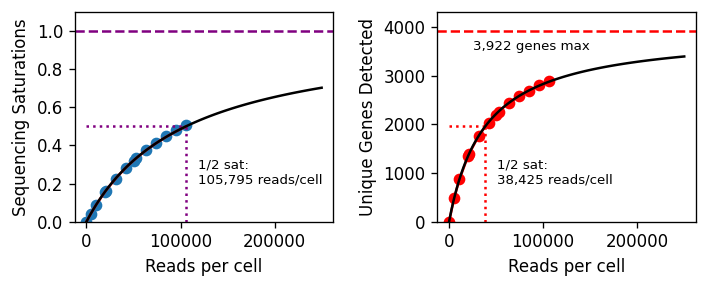

In [22]:
satcurves('web_summary.html')